In [1]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))
sys.path.append(os.path.join(os.getcwd(), "molgen"))


%load_ext autoreload
%autoreload 2

from otgnn.models import GCN
# from molgen.dataloading.MolGraphBatchPreprocessor import MolGraph
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES


from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main, load_checkpoint
from mol_opt.mol_opt import MolOpt
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.ot_utils import encode_target
from mol_opt.ot_utils import FGW 
from mol_opt.ot_utils import compute_barycenter

from molgen.dataloading.feat2smiles import feat2smiles
from molgen.dataloading.mol_drawer import MolDrawer
from molgen.metrics.Penalty import Penalty
from molgen.metrics.mol_metrics import MolMetrics

from rdkit.Chem import MolFromSmiles
from tensorboardX import SummaryWriter

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import time
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from molgen.metrics.Penalty import Penalty as PenaltyNew

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

/home/octav/gitrepos/tum-thesis


In [3]:
model_type = "pointwise"
sys.argv = ["", "-cuda", "-model_type", model_type, "-one_batch_train"]
args = get_args()
outdir_suffix = "dev1"
args.n_epochs = 100 
args.init_model = "{}-test11-eulval-nonormalize-gumbel-notemp1".format(model_type)
args.init_decoder_model = "{}_decode".format(args.init_model)
args.output_dir = "mol_opt/output_{}/{}/".format(outdir_suffix, args.init_model)
args.tb_logs_dir = "mol_opt/logs_{}/{}/".format(outdir_suffix, args.init_model)
args.batch_size = 50 

In [26]:
model = args.init_model
model_iter = 590 

model_name = "model_{}_{}".format(model, model_iter)
print(args.output_dir + model_name)
model_decode_name = "model_{}_decode_{}".format(model, model_iter)

molopt, molopt_decoder, _, _, config, _ = load_checkpoint(args.output_dir + model_name)

metrics = MolMetrics(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, False)
fgw_loss = FGW(alpha = 0.5)
pen = PenaltyNew(config, model_iter)

molopt_module_list = torch.nn.ModuleList([molopt, molopt_decoder])

# molopt = MolOpt(args)
# molopt_decoder = MolOptDecoder(args)
print (molopt)
print (molopt_decoder)
print(molopt.args.model_type)
pen.log()

mol_opt/output_dev1/pointwise-test11-eulval-nonormalize-gumbel-notemp1/model_pointwise-test11-eulval-nonormalize-gumbel-notemp1_590
MolOpt(
  (GCN): GCN(
    (W_message_i): Linear(in_features=100, out_features=250, bias=False)
    (W_message_h): Linear(in_features=250, out_features=250, bias=False)
    (W_message_o): Linear(in_features=343, out_features=100, bias=True)
    (W_mol_h): Linear(in_features=100, out_features=100, bias=True)
    (W_mol_o): Linear(in_features=100, out_features=1, bias=True)
    (dropout_gcn): Dropout(p=0.0, inplace=False)
    (dropout_ffn): Dropout(p=0.0, inplace=False)
  )
  (opt0): Linear(in_features=100, out_features=250, bias=True)
  (opt1): Linear(in_features=250, out_features=100, bias=True)
)
MolOptDecoder(
  (fc1_SYMBOLS): Linear(in_features=100, out_features=150, bias=True)
  (fc2_SYMBOLS): Linear(in_features=150, out_features=64, bias=True)
  (fc1_CHARGES): Linear(in_features=100, out_features=150, bias=True)
  (fc2_CHARGES): Linear(in_features=150,

In [27]:
train_data_loader = get_loader("iclr19-graph2graph/data/qed", "train_pairs", args.batch_size, True)

for i in train_data_loader:
    X = (MolGraph(i[0]))
    Y = (MolGraph(i[1]))
    break

In [28]:
x_embedding = molopt.forward(X)
yhat_logits = molopt_decoder.forward(x_embedding, X, Y)
# yhat_labels = molopt_decoder.discretize_argmax(*yhat_logits)
yhat_labels = molopt_decoder.discretize_gumbel(*yhat_logits, tau = pen.tau)
pred_pack = (yhat_labels, yhat_logits, Y.scope), Y 

target = Y.get_graph_outputs()
symbols_labels, charges_labels, bonds_labels = yhat_labels
symbols_logits, charges_logits, bonds_logits = yhat_logits

fgw_loss_item = fgw_loss(*pred_pack, tau = 1)
print (fgw_loss_item.item()/args.batch_size)
pen_loss = pen(*pred_pack, model_iter)
print (pen_loss)
metrics.measure_batch(pred_pack[0], target)

FGW torch.Size([23571, 5]) 0.000157271497300826
1.2479132080078126
logits grad 0.036484166979789734
logits grad 1.9044333032227842e-14
logits grad 0.03736814856529236
logits grad 1.2685016673446852e-23
logits grad 0.03731687739491463
logits grad 4.720398758871464e-22
logits grad 0.03419344127178192
logits grad 1.7581487346159413e-17
logits grad 0.03551442548632622
logits grad 1.2229719190473554e-13
bonds_prob grad torch.Size([23571, 5]) 0.02144160121679306
bonds_prob_conn grad torch.Size([23571, 5]) 0.02144160121679306
bonds_logits grad torch.Size([23571, 5]) 0.02874915674328804
(tensor(0., device='cuda:0'), tensor(59.2963, device='cuda:0', grad_fn=<DivBackward0>), tensor(28.3396, device='cuda:0', grad_fn=<DivBackward0>))


({'batch_molecular_validity': 0.0,
  'batch_correctness': 0.0,
  'batch_symbol_accuracy': 57.83132530120482,
  'batch_molecular_disconnected_validity': 0.0,
  'batch_connected_components': 1.0,
  'batch_invalid_valency_nodes': 76.64504170528267,
  'batch_nodes_0degree': 110,
  'batch_nodes_7plus_degree': 6,
  'invalid_euler_toofew': 24.0,
  'invalid_euler_toomany': 14.0},
 {'avg_euler_error': (1.75, 50, 14.4325),
  'batch_node_degree': (2.1881371640407785, 1079, 2.010016826413088)})

In [29]:
(bonds_labels[22*22:22*22 + 18*18] != 4).sum()/2.

tensor(23.5000, device='cuda:0')

In [30]:
[x.item() / args.batch_size for x in pen_loss]

[0.0, 1.1859256744384765, 0.5667916488647461]

In [31]:
G_euler = grad(pen_loss[2], bonds_logits, retain_graph = True)
G_euler

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 7.2346e-32,  0.0000e+00,  3.4652e-24,  5.9663e-33,  0.0000e+00],
         [-9.8547e-26, -3.6876e-40,  0.0000e+00,  2.1030e-20,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],
        device='cuda:0'),)

In [32]:
G_fgw = grad(fgw_loss_item, x_embedding, retain_graph = True)
G_fgw

(tensor([[ 1.5790e-03, -2.7603e-03,  3.2111e-03,  ..., -1.3019e-03,
          -3.7149e-03,  1.4785e-03],
         [-4.2863e-03,  6.7773e-03, -8.8071e-03,  ..., -6.9252e-05,
           4.0330e-03, -7.3604e-03],
         [ 3.3736e-04, -2.3280e-03,  5.9404e-03,  ..., -3.8399e-03,
          -1.1127e-03,  5.4059e-03],
         ...,
         [-1.0837e-03, -4.7421e-03,  9.6093e-03,  ..., -5.2685e-03,
          -2.5589e-03,  5.2629e-03],
         [-6.2311e-06, -3.3424e-03,  4.6113e-03,  ..., -1.5356e-03,
          -3.6813e-03,  4.7741e-04],
         [ 3.6485e-04, -3.3874e-03,  3.1666e-03,  ...,  1.4501e-05,
          -4.1843e-03, -9.5086e-04]], device='cuda:0'),)

In [33]:
print(G_euler[0].abs().mean().item())
print(G_fgw[0].abs().mean().item())
print()
print(np.mean((torch.sum(G_euler[0], dim = 1) == 0).cpu().detach().numpy()))
print(np.mean((torch.sum(G_fgw[0], dim = 1) == 0).cpu().detach().numpy()))
print()
print(symbols_logits.abs().mean().item())
print(bonds_logits.abs().mean().item())

0.005749830976128578
0.0027951959054917097

0.2254889482839082
0.0

2.808225631713867
3.5249361991882324


In [34]:
bonds_logits_softmaxed = nn.Softmax(dim = 1)(bonds_logits)

In [35]:
grad(bonds_logits_softmaxed[:,4].sum(), bonds_logits, retain_graph = True)[0].sum()

tensor(-1.4663e-05, device='cuda:0')

In [36]:
bonds_logits_softmaxed

tensor([[2.2790e-03, 3.7638e-03, 1.4015e-04, 1.0172e-01, 8.9210e-01],
        [1.4939e-02, 5.5420e-03, 4.8060e-04, 1.1370e-01, 8.6534e-01],
        [1.0797e-02, 3.6213e-03, 2.5095e-04, 1.0275e-01, 8.8258e-01],
        ...,
        [2.3835e-04, 8.6947e-04, 9.8702e-06, 7.4912e-02, 9.2397e-01],
        [1.6419e-04, 1.0937e-03, 9.5729e-06, 7.5045e-02, 9.2369e-01],
        [4.0895e-05, 4.6994e-04, 2.0273e-06, 6.4010e-02, 9.3548e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [37]:
x_embedding.shape

torch.Size([1079, 100])

In [38]:
bond_idx = 0
smiles = []

yhat = []
yact = []
for mol_idx, (st, le) in enumerate(Y.scope):
    symbols = symbols_labels[st:st+le]
    charges = charges_labels[st:st+le]
    bonds = bonds_labels[bond_idx:bond_idx+le*le].view(le, le)
    bond_idx += le * le
    smiles.append(feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols, charges, bonds, False))
    yhat.append(le)
    yact.append((bonds != 4).sum().item()/2.)
    print (mol_idx, yact[-1], le)
    print (smiles[-1])
    
yhat = np.array(yhat)
yact = np.array(yact)


0 22.5 22
cc-c[ru]1c-s([ni])c(p)cs2-[si](c)c-2(c[hf]2(C)cc2)-s1.cs
1 23.5 18
C[hg]p1[se]23s([hf])c1-24[pd]c[mo]312[ni]cs=13=[hf]1[sm]c2-3([fe])c14
2 22.0 21
S.[AlH3].[mo]c1-[ru]p-12-ccC2.cc-[hg](c)(so[rh](c)[Mo])p(c)s
3 23.5 18
C.C.C[mo]123[rh]4-c5s67(p-5)[rh]c65c-4p514(c[Hg]c4-2C7)p-3.[Mo]
4 22.5 21
C.cc[cu]12[mn]c[ni]-c34c5[v]6(S)(c(-cp)-c31-5c6n)=[Sb]c2-p4[pd]
5 17.5 20
C.C.Sc[cr].[Zr]=[Cd].ccc(c[hg]n[cu][zr])ps.s1[hg][hg]1
6 26.5 24
C.cc([cr])[siH]c1c2([pt])n3cc14(c-[tc]c1(C)ccs2-1c4)c3.cs.s[rh]
7 24.0 20
[Nb].[Tc].s[sb][rh]1cc(s)[nb]([Mo])-c2c3c45c-3s4-23c2c3C1c-5c-2
8 24.5 22
C.C.C.c[hf]c12[se](cS)cc([siH]-c-1c)[cu]-c2(C)C.c[nb](C)[asH]
9 16.0 19
C.C.[Hf].cc(cp(c)(c)c)-s(-[hg][mo])c(pS)s(c)C
10 16.5 21
C.C.CS.S.S.[Hf].[Rh].[pd]c[sbH].cc(c)-c(c[mo])c(S)[Pt][AlH2]
11 28.5 25
cncc1c2[cd][Rh][al]3(c)[sm](C)(C)[ni]4([Hg])p5sc-s1(c)([re])s-31=c2-4-c5-1.cs
12 26.5 25
C.C.S.sc1c[mo]23c4c5[gd][hf]46c1-[pt][mn](c-c1c-s2(S)[hf]c-3CSC1)c-5-6
13 27.0 22
C.ccc[cd]1c(-sc)c(c)([sm])-[hf]2(c)([mo

(array([ 6.,  7.,  8., 13.,  7.,  5.,  2.,  0.,  1.,  1.]),
 array([-3.5 , -1.95, -0.4 ,  1.15,  2.7 ,  4.25,  5.8 ,  7.35,  8.9 ,
        10.45, 12.  ]),
 <a list of 10 Patch objects>)

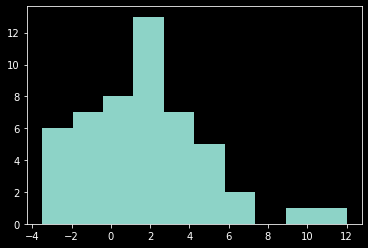

In [18]:
plt.hist(yact - yhat)

In [43]:
Chem.MolFromSmiles(smiles[9], sanitize = False)

In [102]:
(bonds != 4).sum() / 2.

tensor(26., device='cuda:0')

In [21]:
mol_idx = 0 
torch.argmax(target[mol_idx]['SYMBOLS'], dim=1)

tensor([0, 0, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0])

In [22]:
(x_embedding.mean(axis = 0) / x_embedding.std(axis = 0)).abs().max()

tensor(1.9599, device='cuda:0', grad_fn=<MaxBackward1>)

In [26]:
target_smiles = [Chem.MolToSmiles(y) for y in Y.rd_mols]
initial_smiles = [Chem.MolToSmiles(y) for y in X.rd_mols]

# uncomment for tensorboard
tb_writer = SummaryWriter(logdir = args.tb_logs_dir)
mol_drawer = MolDrawer(tb_writer, SYMBOLS, BOND_TYPES, FORMAL_CHARGES)
mol_drawer.visualize_batch(pred_pack[0], target_smiles, model_iter, initial_smiles, text="{}-manual2-".format(args.init_model))

C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.N.O.O.S
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.N
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.F.N.N.O.O.O
C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.N.N.O
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.O.O.O.O
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.O.O.O
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.O.O.O.O
C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.N.O.O.S.S
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.N.N.O.O
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.O.S
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.N.O.O
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.N.N.N
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.N.N.N.O
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.F.N.O.O.O
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.O.O.O
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.O.O
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.F.N.O.O
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.N.N.O.O.O
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.O.O.O
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.N.O
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.F.N.N.O.O
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.N.N.N.O
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.O


In [27]:
feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols, charges, bonds, False)

'C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.O.O.O.O'

In [39]:
tau = pen.tau
# tau = 0.001
# symbols_nll, charges_nll, bonds_nll = F.gumbel_softmax(tau = tau, dim=1, logits = symbols_logits), F.gumbel_softmax(tau=tau,dim=1,logits=charges_logits), F.gumbel_softmax(tau=tau,dim=1, logits = bonds_logits)
# symbols_nll, charges_nll, bonds_nll = -nn.LogSoftmax(dim=1)(symbols_logits/tau),\
#              -nn.LogSoftmax(dim=1)(charges_logits/tau), -nn.LogSoftmax(dim=1)(bonds_logits/tau)

def softmax(logits, tau):
#     logitsn = F.normalize(logits, dim = 1)
#     return -nn.LogSoftmax(dim=1)(logitsn/tau)
    return F.gumbel_softmax(tau = tau, dim=1, logits = logits)

symbols_nll = softmax(symbols_logits, tau)
charges_nll = softmax(charges_logits, tau)
bonds_nll = softmax(bonds_logits, tau)

In [40]:
pen.tau

0.05195383849590577

(array([ 40., 178., 196., 148., 161., 141., 122.,  68.,  22.,   3.]),
 array([18.200134, 20.99893 , 23.797726, 26.596523, 29.395319, 32.194115,
        34.992912, 37.791706, 40.590504, 43.389297, 46.188095],
       dtype=float32),
 <a list of 10 Patch objects>)

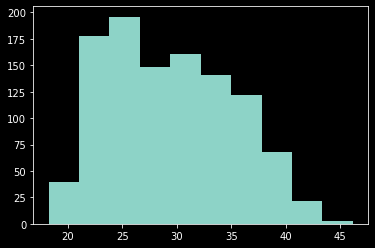

In [41]:
plt.hist(symbols_logits.norm(dim = 1).cpu().detach().numpy())

(array([  1.,   0.,   0.,   2.,   0.,   2.,   1.,   0.,   2.,   0.,   0.,
          1.,   2.,   2.,   0.,   4.,   6.,   4.,   2.,   0.,  14.,  10.,
         22.,  14.,  24.,  42.,  31.,  28.,  62.,  59.,  90., 107., 154.,
        151., 157., 162., 166., 137., 203., 251., 277., 285., 328., 328.,
        343., 401., 401., 453., 430., 532., 632., 592., 610., 660., 648.,
        750., 674., 740., 792., 734., 685., 816., 801., 765., 809., 723.,
        692., 582., 667., 476., 424., 395., 297., 261., 232., 198., 193.,
        155., 137., 153., 125., 146., 126., 128., 124., 110., 126., 100.,
        130., 124., 119.,  77.,  53.,  44.,  27.,   8.,   6.,  10.,   3.,
          1.]),
 array([0.76019484, 0.76257384, 0.76495284, 0.76733184, 0.7697108 ,
        0.7720898 , 0.7744688 , 0.7768478 , 0.7792268 , 0.7816058 ,
        0.7839848 , 0.7863637 , 0.7887427 , 0.7911217 , 0.7935007 ,
        0.7958797 , 0.7982587 , 0.8006377 , 0.80301666, 0.80539566,
        0.80777466, 0.81015366, 0.81253266, 0.

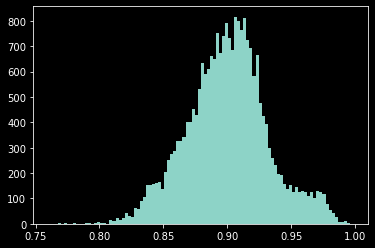

In [42]:
max_logits = torch.max(F.softmax(dim=1, input = bonds_logits), dim = 1).values.detach().cpu().numpy()
plt.hist(max_logits, bins = 100)

In [26]:
symbols_logits.shape

torch.Size([1079, 64])

<BarContainer object of 64 artists>

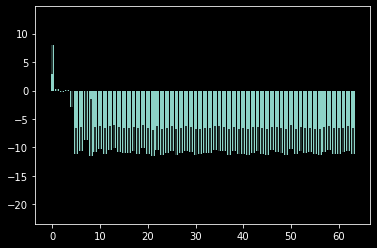

In [70]:
means = symbols_logits.mean(axis = 0).cpu().detach().numpy()
stds = symbols_logits.std(axis = 0).cpu().detach().numpy()
plt.bar(range(len(SYMBOLS)), means, yerr = stds)

<BarContainer object of 5 artists>

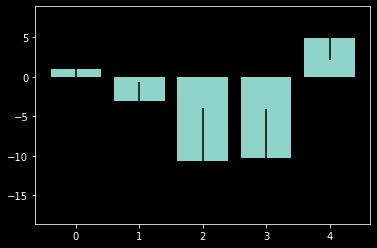

In [71]:
means = bonds_logits.mean(axis = 0).cpu().detach().numpy()
stds = bonds_logits.std(axis = 0).cpu().detach().numpy()
plt.bar(range(len(BOND_TYPES)), means, yerr = stds)

In [101]:
torch.argmax(F.gumbel_softmax(tau = 1, dim=1, logits = symbols_logits), axis = 1)
# torch.argmax(F.softmax(symbols_logits, dim = 1), axis = 1)

tensor([27,  4, 53,  ...,  4,  7, 50], device='cuda:0')

In [102]:
bonds_logits.sum(axis = 1)

tensor([-0.7168, -0.6918, -0.7858,  ..., -0.2435, -0.3567, -0.3224],
       device='cuda:0', grad_fn=<SumBackward1>)

In [103]:
F.gumbel_softmax(tau = 0.1, dim=1, logits = symbols_logits)

tensor([[1.1898e-07, 4.1788e-15, 1.1364e-11,  ..., 1.1246e-15, 4.4671e-12,
         2.6455e-06],
        [5.9730e-32, 3.8587e-35, 2.3728e-35,  ..., 2.7590e-26, 4.3688e-35,
         6.8968e-34],
        [2.3369e-16, 5.9282e-12, 9.6984e-11,  ..., 5.1900e-19, 7.2133e-17,
         2.6491e-13],
        ...,
        [1.0000e+00, 1.0524e-29, 1.8007e-29,  ..., 5.9074e-30, 3.6392e-36,
         2.7992e-31],
        [3.3421e-20, 3.4711e-14, 4.9880e-17,  ..., 4.9878e-09, 9.8660e-22,
         7.0411e-26],
        [5.2386e-27, 2.3484e-27, 5.3644e-35,  ..., 3.0511e-31, 3.9224e-33,
         6.2579e-37]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [104]:
bonds_nll

tensor([[30.4351, 34.9901, 82.9673, 68.6483, -0.0000],
        [35.5620, 39.7150, 82.7646, 71.0517, -0.0000],
        [36.0503, 39.9646, 83.9324, 70.3454, -0.0000],
        ...,
        [26.6836, 38.2859, 91.0719, 90.3248, -0.0000],
        [20.4135, 28.7948, 73.8399, 72.7646, -0.0000],
        [21.0419, 32.0101, 80.5401, 78.0148, -0.0000]], device='cuda:0',
       grad_fn=<NegBackward>)

In [105]:
torch.argmax(bonds_nll, dim = 1).unique(return_counts = True)

(tensor([2, 3, 4], device='cuda:0'),
 tensor([13527, 10041,     3], device='cuda:0'))

In [72]:
bonds_nll

tensor([[4.8684e-40, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.1608e-40, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.1414e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        ...,
        [3.8970e-18, 1.0000e+00, 3.2179e-41, 3.9096e-43, 7.6519e-09],
        [1.8544e-17, 6.8090e-20, 0.0000e+00, 5.7014e-10, 1.0000e+00],
        [0.0000e+00, 5.8267e-28, 0.0000e+00, 0.0000e+00, 1.0000e+00]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [73]:
bond_idx = 0
for st, le in Y.scope:
    bonds_nll_curr = bonds_nll[bond_idx:bond_idx + le**2,:].view(le, le, -1)
    print ((1 - bonds_nll_curr[:,:,4]).sum()/2)
    bond_idx += le**2

tensor(25.9540, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.2943, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15.7227, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.0428, device='cuda:0', grad_fn=<DivBackward0>)
tensor(30.8190, device='cuda:0', grad_fn=<DivBackward0>)
tensor(26.7959, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21.0293, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18.0473, device='cuda:0', grad_fn=<DivBackward0>)
tensor(12.4608, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14.6883, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17.4138, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.8999, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.4789, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.8743, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24.2297, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17.4069, device='cuda:0', grad_fn=<DivBackward0>)
tensor(29.8443, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14.9637, device='cuda:0', g

In [75]:
1 - bonds_nll_curr[:,:,4]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.2863e-01,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 9.3452e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.0364e-02, 0.0000e+00, 9.9963e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         9.9987e-01, 1.9908e-05, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.5497e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 9.4771e-05, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2620e-01, 0.0000e+00, 0.0000e+00,
         9.1592e-01, 3.3100e-03, 0.0000e+00],
        [1.1921e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e

In [118]:
symbols_logits.shape

torch.Size([1079, 64])

In [119]:
symbols_labels

tensor([2, 0, 0,  ..., 0, 0, 0], device='cuda:0')

In [110]:
bonds_labels.unique(return_counts = True)

(tensor([0, 1, 4], device='cuda:0'),
 tensor([   89,     6, 23476], device='cuda:0'))

# inspect module parameters

In [150]:
molopt_decoder.fc1_SYMBOLS

Linear(in_features=100, out_features=150, bias=True)

In [151]:
molopt_decoder.fc2_SYMBOLS(F.leaky_relu(molopt_decoder.fc1_SYMBOLS(x_embedding)))

tensor([[ 13.7881,   0.6913,   3.3530,  ..., -10.6195,  -8.9924, -11.0378],
        [ 13.5698,  -1.3311,   4.9047,  ...,  -8.9976,  -7.9215, -10.1074],
        [  5.2691,  -6.6067,   3.9132,  ..., -13.3723, -13.1498, -14.1045],
        ...,
        [  2.3633,   0.6043,   8.5959,  ..., -12.3276, -12.1154, -13.7442],
        [ 16.1051,   0.3792,   4.5413,  ...,  -8.0192,  -7.4203,  -9.7780],
        [  8.6492,   4.9261,   0.4580,  ...,  -9.5743,  -9.4313, -10.6167]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [152]:
x_embedding

tensor([[-0.1335,  0.4283,  0.3699,  ..., -0.3710,  0.7165, -0.5101],
        [-0.8927,  1.3656,  0.6950,  ..., -1.0309, -0.1640, -0.0162],
        [-0.4414, -0.3376,  2.9654,  ...,  1.0029, -0.6166,  0.1708],
        ...,
        [ 0.9006,  0.2762, -0.7614,  ...,  1.1360,  0.2881, -0.2464],
        [-1.4002,  1.4269, -0.5393,  ..., -1.6091,  0.4275, -0.0564],
        [-0.5014,  0.6323,  0.1265,  ..., -1.6008, -0.1383,  0.4430]],
       device='cuda:0', grad_fn=<AddBackward0>)

# debug connectivity

In [153]:
def get_pen(model_iter):
    model_name = "model_{}_{}".format(model, model_iter)
    model_decode_name = "model_{}_decode_{}".format(model, model_iter)
    molopt, config = load_model(args.output_dir + model_name, MolOpt, args.device)
    molopt_decoder, config_decoder = load_model(args.output_dir + model_decode_name, MolOptDecoder, args.device)
    x_embedding = molopt.forward(X)
    yhat_logits = molopt_decoder.forward(x_embedding, X, Y)
    yhat_labels = molopt_decoder.discretize_argmax(*yhat_logits)
    # yhat_labels = molopt_decoder.discretize(*yhat_logits)
    pred_pack = (yhat_labels, yhat_logits, Y.scope), Y 

    return (pen(*pred_pack, model_iter)[1].item())

In [154]:
for i in range(0, 2000):
    print (i, get_pen(1600))

FileNotFoundError: [Errno 2] No such file or directory: 'mol_opt/output_transformer10-onebatch/model_transformer10-onebatch-nonconstrained_1600'

In [ ]:
# adjM = pen_loss
# N = adjM.shape[0]
# device = adjM.device
# # We need the laplacian otherwise
# L = torch.diag(torch.matmul(adjM, torch.ones(N, device=device))) - adjM # Laplacian
# L_mod = L + torch.ones_like(L, device=device) / N
# eigenvals = torch.symeig(L_mod + 1e-06 * torch.eye(N, device=device), eigenvectors=True)[0]
# -torch.sum(torch.log(eigenvals.clamp(max = 1e-01))) + len(eigenvals) * np.log(1e-01)

In [ ]:
F.gumbel_softmax(symbols_logits, dim=1, tau=0.5)